### Importing Libaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import torch
from TextCleaner import TextCleaner
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from scipy.special import softmax
from nltk.tokenize import sent_tokenize
from collections import Counter
import re
from wordcloud import WordCloud
import warnings
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
warnings.filterwarnings("ignore")

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Preload resources
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


c:\Users\yashj\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yashj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yashj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yashj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Getting Data

In [2]:
#### Apple iPhone XR (64GB) - Black

data = pd.read_csv('Data/apple_iphone_11_reviews.csv')
data.head()

,product,helpful_count,total_comments,review_country,reviewed_at,review_text,Review rating out of 5,review_title
0,Apple iPhone XR (64GB) - Black,"5,087",24,India,12/12/18,NOTE:,3,"Which iPhone you should Purchase ? iPhone 8, X..."
1,Apple iPhone XR (64GB) - Black,"2,822",6,India,11/17/18,Very bad experience with this iPhone xr phone....,1,Don't buy iPhone xr from Amazon.
2,Apple iPhone XR (64GB) - Black,"1,798",0,India,1/27/19,Amazing phone with amazing camera coming from ...,5,Happy with the purchase
3,Apple iPhone XR (64GB) - Black,"1,366",14,India,5/2/19,So I got the iPhone XR just today. The product...,1,Amazon is not an apple authorised reseller. Pl...
4,Apple iPhone XR (64GB) - Black,536,5,India,5/24/19,I've been an android user all my life until I ...,5,Excellent Battery life and buttery smooth UI


### Data Exploration and Cleaning

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5010 entries, 0 to 5009
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   product                 5010 non-null   object
 1   helpful_count           5010 non-null   object
 2   total_comments          5010 non-null   int64 
 3   review_country          5010 non-null   object
 4   reviewed_at             5010 non-null   object
 5   review_text             5007 non-null   object
 6   Review rating out of 5  5010 non-null   int64 
 7   review_title            5008 non-null   object
dtypes: int64(2), object(6)
memory usage: 313.3+ KB


In [4]:
data.rename(columns={'Review rating out of 5': 'rating'},inplace=True)
data['helpful_count'] = data['helpful_count'].str.replace(',', '').astype(int)
data.head()

,product,helpful_count,total_comments,review_country,reviewed_at,review_text,rating,review_title
0,Apple iPhone XR (64GB) - Black,5087,24,India,12/12/18,NOTE:,3,"Which iPhone you should Purchase ? iPhone 8, X..."
1,Apple iPhone XR (64GB) - Black,2822,6,India,11/17/18,Very bad experience with this iPhone xr phone....,1,Don't buy iPhone xr from Amazon.
2,Apple iPhone XR (64GB) - Black,1798,0,India,1/27/19,Amazing phone with amazing camera coming from ...,5,Happy with the purchase
3,Apple iPhone XR (64GB) - Black,1366,14,India,5/2/19,So I got the iPhone XR just today. The product...,1,Amazon is not an apple authorised reseller. Pl...
4,Apple iPhone XR (64GB) - Black,536,5,India,5/24/19,I've been an android user all my life until I ...,5,Excellent Battery life and buttery smooth UI


In [5]:
data.duplicated().sum()

np.int64(38)

In [6]:
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

In [7]:
data.shape

(4969, 8)

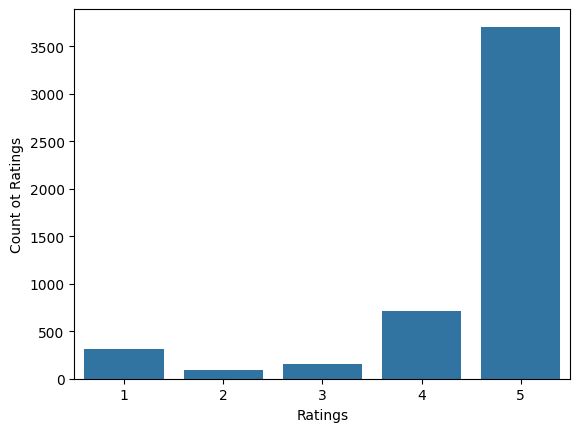

In [8]:
sns.countplot(x='rating', data=data)
plt.xlabel("Ratings")
plt.ylabel("Count ot Ratings")
plt.show()

In [9]:
### Grouping by rating to see how people interact with the comments
helpful_rating_group = data.groupby('rating')['helpful_count'].agg(
    helpful_mean_amount='mean',
    helpful_max_amount='max',
    helpful_total_amount='sum',
    count = 'count'
).reset_index()

total_comments_rating_group = data.groupby('rating')['total_comments'].agg(
    total_comments_mean_amount='mean',
    total_comments_max_amount='max',
    total_comments_total_amount='sum',
).reset_index()

total_comments_rating_group = total_comments_rating_group.merge(helpful_rating_group,how='left',on='rating')
total_comments_rating_group

,rating,total_comments_mean_amount,total_comments_max_amount,total_comments_total_amount,helpful_mean_amount,helpful_max_amount,helpful_total_amount,count
0,1,0.134185,14,42,17.079872,2822,5346,313
1,2,0.022989,1,2,1.252874,62,109,87
2,3,0.171053,24,26,34.493421,5087,5243,152
3,4,0.008439,1,6,0.357243,124,254,711
4,5,0.006206,5,23,0.995143,1798,3688,3706


In [10]:
data.sort_values('helpful_count', ascending=False).head(10)

,product,helpful_count,total_comments,review_country,reviewed_at,review_text,rating,review_title
0,Apple iPhone XR (64GB) - Black,5087,24,India,12/12/18,NOTE:,3,"Which iPhone you should Purchase ? iPhone 8, X..."
1,Apple iPhone XR (64GB) - Black,2822,6,India,11/17/18,Very bad experience with this iPhone xr phone....,1,Don't buy iPhone xr from Amazon.
2,Apple iPhone XR (64GB) - Black,1798,0,India,1/27/19,Amazing phone with amazing camera coming from ...,5,Happy with the purchase
3,Apple iPhone XR (64GB) - Black,1366,14,India,5/2/19,So I got the iPhone XR just today. The product...,1,Amazon is not an apple authorised reseller. Pl...
4,Apple iPhone XR (64GB) - Black,536,5,India,5/24/19,I've been an android user all my life until I ...,5,Excellent Battery life and buttery smooth UI
5,Apple iPhone XR (64GB) - Black,313,2,India,4/22/19,I was delivered a phone that did not work imme...,1,Never purchase a phone online.
6,Apple iPhone XR (64GB) - Black,189,3,India,12/7/18,It has been a month since I started using my i...,5,Awesome iPhone
7,Apple iPhone XR (64GB) - Black,164,1,India,11/25/18,The phone is hanging. Video quality is not ver...,1,Exchange of I phone xr with xs.
8,Apple iPhone XR (64GB) - Black,124,1,India,4/27/19,I'll use this review to mostly say what I'm no...,4,Worth upgrading from the 6S? I'll know in a fe...
9,Apple iPhone XR (64GB) - Black,94,0,India,4/21/19,Went with the iPhone XR after over a month of ...,1,Def a bad experience


In [11]:
raw_data = data.copy()

### Cleaning review text

In [12]:
custom_stopwords = ['iphone', 'apple', 'camera', 'product', 'amazon', 'xr', 'x', 'phone','xs','authorize']
textCleaner = TextCleaner(remove_non_ascii=True, keep_currency_symbols=False,custom_keywords=custom_stopwords)
data['review_text']=data['review_text'].apply(textCleaner.clean)
data['review_title']=data['review_title'].apply(textCleaner.clean)

In [13]:
data.head()

,product,helpful_count,total_comments,review_country,reviewed_at,review_text,rating,review_title
0,Apple iPhone XR (64GB) - Black,5087,24,India,12/12/18,note,3,purchase NUMBER
1,Apple iPhone XR (64GB) - Black,2822,6,India,11/17/18,bad experience back find defective non functio...,1,dont buy
2,Apple iPhone XR (64GB) - Black,1798,0,India,1/27/19,amaze amaze come NUMBER plus great service,5,happy purchase
3,Apple iPhone XR (64GB) - Black,1366,14,India,5/2/19,get today look amaze unfortunately face id wor...,1,authorise reseller please take note
4,Apple iPhone XR (64GB) - Black,536,5,India,5/24/19,ive android user life decide try ios love batt...,5,excellent battery life buttery smooth ui


In [14]:
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)
data = data[data.review_text!=''].copy()

In [15]:
data.shape

(4870, 8)

### WordCloud

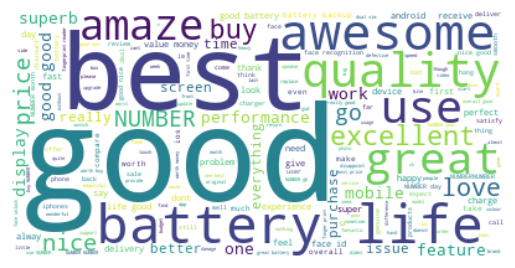

In [16]:
text = " ".join(review for review in data['review_text'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [17]:
data_reviews = data[['review_title','review_text','rating']].copy()
data_reviews['raw_review_text'] = raw_data['review_text']
data_reviews

,review_title,review_text,rating,raw_review_text
0,purchase NUMBER,note,3,NOTE:
1,dont buy,bad experience back find defective non functio...,1,Very bad experience with this iPhone xr phone....
2,happy purchase,amaze amaze come NUMBER plus great service,5,Amazing phone with amazing camera coming from ...
3,authorise reseller please take note,get today look amaze unfortunately face id wor...,1,So I got the iPhone XR just today. The product...
4,excellent battery life buttery smooth ui,ive android user life decide try ios love batt...,5,I've been an android user all my life until I ...
...,...,...,...,...
5005,dhamaka,dhamaka,4,Dhamaka
5006,good,goodbye,4,Goodbye
5007,fantabulous easy use,nothing,5,Nothing
5008,fantastic,superbb,5,Superbb


### Sentiment Analysis

#### Textblob

In [18]:
data_textblob = data.copy()

In [19]:
polarity = []
subjectivity = []
for i in data_textblob['review_text'].values:
    try:
        analysis = TextBlob(i)
        polarity.append(analysis.sentiment.polarity)
        subjectivity.append(analysis.sentiment.subjectivity)
    except:
        polarity.append(0)
        subjectivity.append(0)

data_textblob['polarity'] = polarity
data_textblob['subjectivity'] = subjectivity

In [20]:
bins = np.linspace(-1, 1, 6) 
data_textblob['updated_rating'] = np.clip(np.digitize(data_textblob.polarity, bins, right=False), 1, 5)
data_textblob['diff'] = data_textblob['updated_rating'] - data_textblob['rating']
data_textblob['diff'].value_counts().sort_index()

diff
-4       5
-3      31
-2     797
-1    1347
 0    2003
 1     393
 2     229
 3      46
 4      19
Name: count, dtype: int64

In [21]:
data_reviews[['text_blob_polarity','text_blob_rating']] = data_textblob[['polarity','updated_rating']].copy()

#### VADER

In [22]:
data_vader = data.copy()

In [23]:
vader_analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    scores = vader_analyzer.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        sentiment = "Positive"
    elif compound <= -0.05:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
    return pd.Series([sentiment, compound])

data_vader[['Sentiment', 'Compound_Score']] = data_vader['review_text'].apply(vader_sentiment)

In [24]:
data_vader.Sentiment.value_counts()

Sentiment
Positive    3932
Neutral      617
Negative     321
Name: count, dtype: int64

In [25]:
data_vader['updated_rating'] = np.clip(np.digitize(data_vader.Compound_Score, bins, right=False), 1, 5)
data_vader['diff'] = data_vader['updated_rating'] - data_vader['rating']
data_vader['diff'].value_counts().sort_index()

diff
-4       4
-3      55
-2     455
-1    1565
 0    2144
 1     407
 2     139
 3      73
 4      28
Name: count, dtype: int64

In [26]:
data_reviews[['vader_score','vader_sentiment','vader_rating']] = data_vader[['Compound_Score','Sentiment','updated_rating']].copy()

#### RoBERTa

In [27]:
data_RoBERTa = data.copy()

In [28]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

labels = ['Negative', 'Neutral', 'Positive']

def analyze_sentiment(text):
    encoded = tokenizer(text, return_tensors='pt', truncation=True)
    with torch.no_grad():
        output = model(**encoded)
    scores = output.logits[0].numpy()
    probs = softmax(scores)
    sentiment = labels[probs.argmax()]
    confidence = probs.max()
    return sentiment, confidence

data_RoBERTa[['Sentiment', 'Compound_Score']] = data_RoBERTa['review_text'].apply(lambda x: pd.Series(analyze_sentiment(x)))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [29]:
data_RoBERTa.Sentiment.value_counts()

Sentiment
Positive    3171
Neutral     1406
Negative     293
Name: count, dtype: int64

In [30]:
bins = np.linspace(0, 1, 6) 
data_RoBERTa['updated_rating'] = np.clip(np.digitize(data_RoBERTa.Compound_Score, bins, right=False), 1, 5)
data_RoBERTa['diff'] = data_RoBERTa['updated_rating'] - data_RoBERTa['rating']
data_RoBERTa['diff'].value_counts().sort_index()

diff
-3       1
-2     715
-1    1570
 0    1830
 1     336
 2     164
 3     162
 4      92
Name: count, dtype: int64

In [31]:
data_reviews[['RoBERTa_score','RoBERTa_sentiment','RoBERTa_rating']] = data_RoBERTa[['Compound_Score','Sentiment','updated_rating']].copy()

#### Zero-Shot Classification

In [32]:
data_zero = data.copy()

In [33]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
data_zero = data_zero[data_zero['review_text'].str.strip().ne("")]

candidate_labels = ["Positive", "Negative", "Neutral"]

results = [classifier(text, candidate_labels) for text in data_zero.review_text]

Device set to use cpu


In [34]:
data_zero['Predicted_Sentiment'] = [res['labels'][0] for res in results]
data_zero['Confidence_score'] = [res['scores'][0] for res in results]

In [35]:
data_zero.Predicted_Sentiment.value_counts()

Predicted_Sentiment
Positive    4024
Negative     747
Neutral       99
Name: count, dtype: int64

In [36]:
bins = np.linspace(0, 1, 6) 
data_zero['updated_rating'] = np.clip(np.digitize(data_zero.Confidence_score, bins, right=False), 1, 5)
data_zero['diff'] = data_zero['updated_rating'] - data_zero['rating']
data_zero['diff'].value_counts().sort_index()

diff
-3      54
-2     366
-1     658
 0    2821
 1     524
 2     159
 3     101
 4     187
Name: count, dtype: int64

In [37]:
data_reviews[['zeroShot_score','zeroShot_sentiment','zeroShot_rating']] = data_zero[['Confidence_score','Predicted_Sentiment','updated_rating']].copy()

### Comparison of Various Methods

In [38]:
data_reviews.rename(columns={'rating':'user_rating'},inplace=True)
data_reviews.head()

,review_title,review_text,user_rating,raw_review_text,text_blob_polarity,text_blob_rating,vader_score,vader_sentiment,vader_rating,RoBERTa_score,RoBERTa_sentiment,RoBERTa_rating,zeroShot_score,zeroShot_sentiment,zeroShot_rating
0,purchase NUMBER,note,3,NOTE:,0.000000,3,0.0000,Neutral,3,0.596637,Neutral,3,0.385759,Negative,2
1,dont buy,bad experience back find defective non functio...,1,Very bad experience with this iPhone xr phone....,-0.225000,2,-0.8468,Negative,1,0.944868,Negative,5,0.985421,Negative,5
2,happy purchase,amaze amaze come NUMBER plus great service,5,Amazing phone with amazing camera coming from ...,0.800000,5,0.9206,Positive,5,0.961717,Positive,5,0.958686,Positive,5
3,authorise reseller please take note,get today look amaze unfortunately face id wor...,1,So I got the iPhone XR just today. The product...,-0.040043,3,0.6597,Positive,5,0.513260,Neutral,3,0.957613,Negative,5
4,excellent battery life buttery smooth ui,ive android user life decide try ios love batt...,5,I've been an android user all my life until I ...,0.464286,4,0.9477,Positive,5,0.928146,Positive,5,0.955777,Positive,5


In [39]:
#### Generating Sentiment : <=2 Negative, ==3 Neutral, >=4 Positive 
data_reviews['text_blob_sentiment'] =np.where( data_reviews['text_blob_rating'] < 3, 'Negative', np.where(data_reviews['text_blob_rating'] == 3, 'Neutral', 'Positive'))
data_reviews['user_sentiment'] =np.where( data_reviews['user_rating'] < 3, 'Negative', np.where(data_reviews['user_rating'] == 3, 'Neutral', 'Positive'))

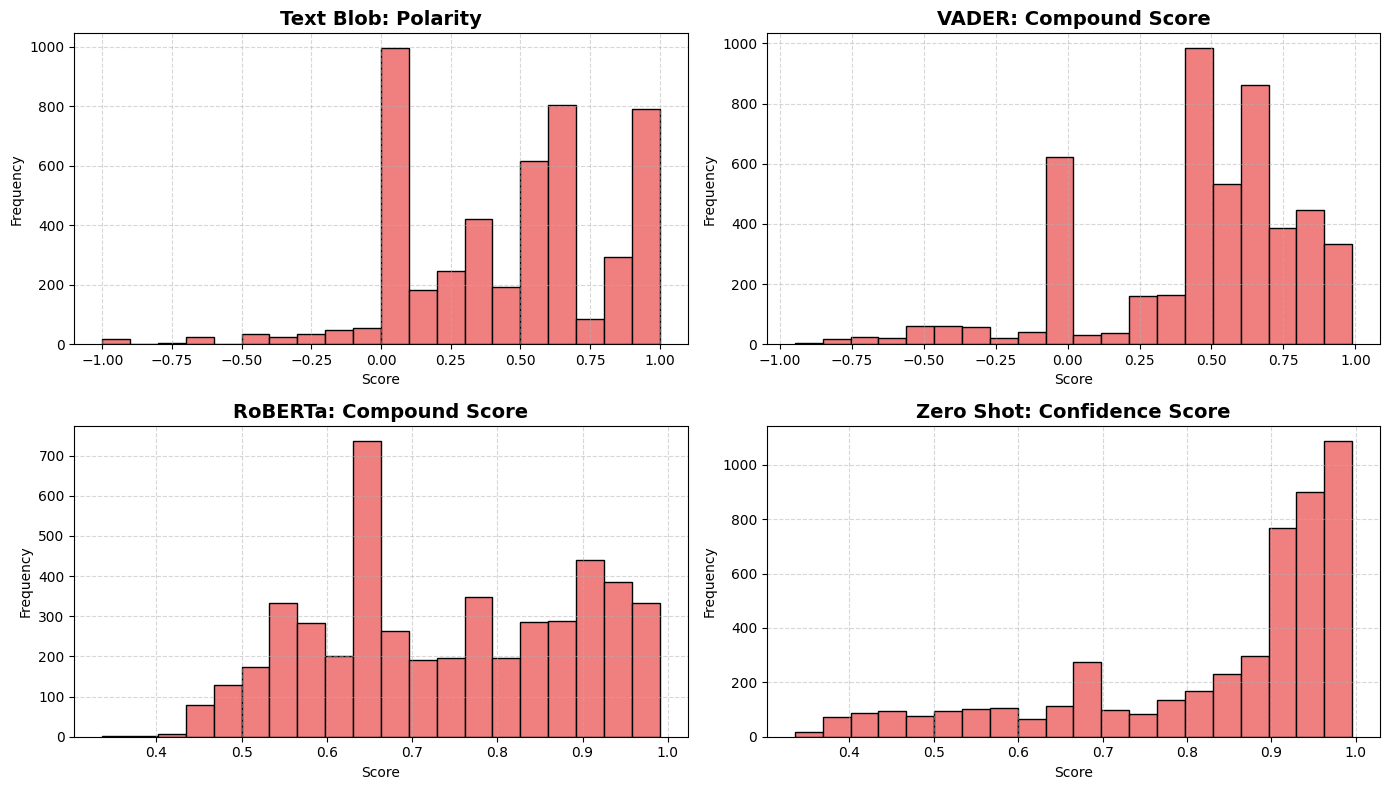

In [40]:
scores = ['Polarity', 'Compound Score', 'Compound Score', 'Confidence Score']
columns = ['text_blob_polarity','vader_score','RoBERTa_score','zeroShot_score']
titles = ['Text Blob', 'VADER', 'RoBERTa', 'Zero Shot']

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

# Loop through datasets and plot histograms
for i,column in enumerate(columns):
    axes[i].hist(data_reviews[column], bins=20, color='lightcoral', edgecolor='black')
    axes[i].set_title(f"{titles[i]}: {scores[i]}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Layout fix
plt.tight_layout()
plt.show()

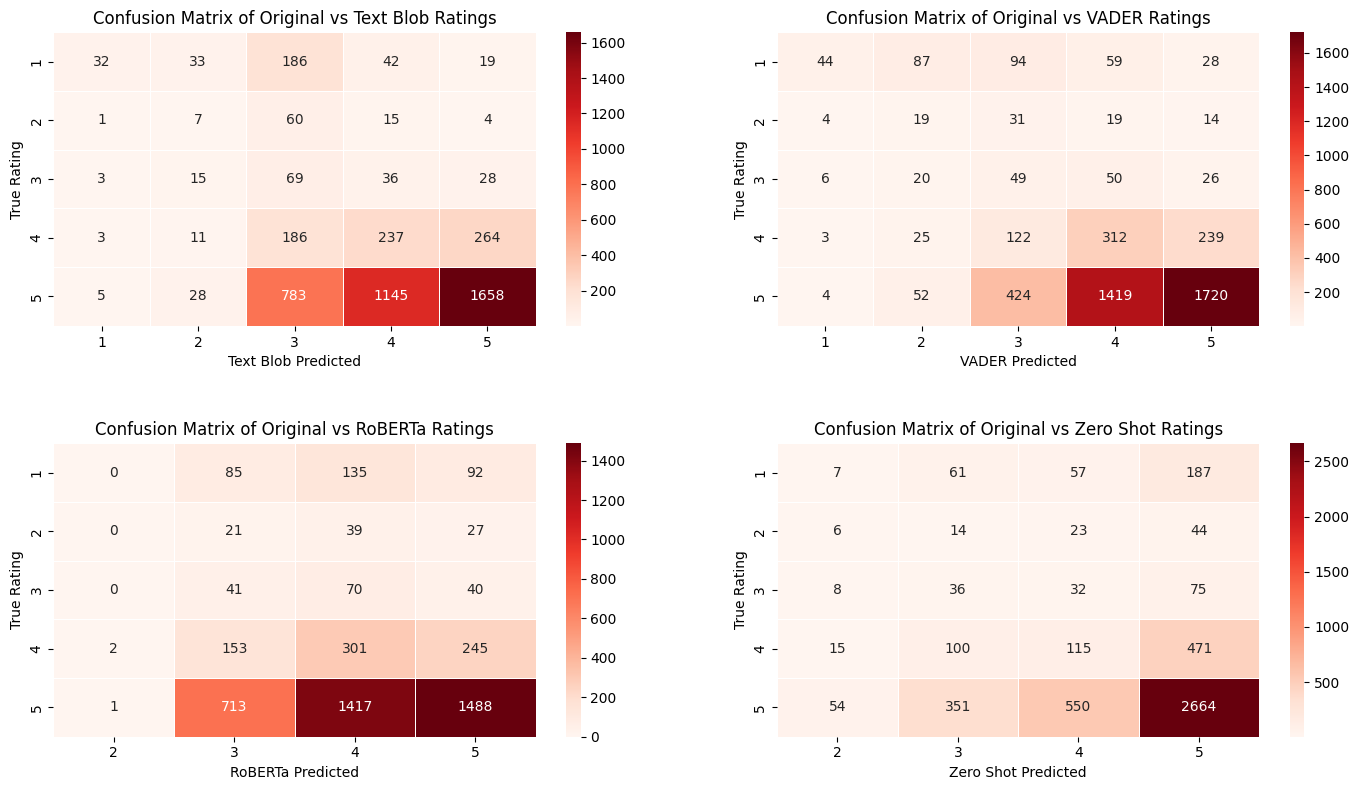

In [41]:
columns = ['text_blob_rating', 'vader_rating', 'RoBERTa_rating', 'zeroShot_rating']
titles = ['Text Blob', 'VADER', 'RoBERTa', 'Zero Shot']

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

# Loop through datasets and plot histograms
for i,column in enumerate(columns):
    conf_matrix = pd.crosstab(data_reviews['user_rating'], data_reviews[column], rownames=['Original'], colnames=[titles[i]])
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',ax=axes[i], linewidths=0.5)
    axes[i].set_title(f'Confusion Matrix of Original vs {titles[i]} Ratings')
    axes[i].set_xlabel(f'{titles[i]} Predicted', fontsize=10)
    axes[i].set_ylabel('True Rating', fontsize=10)

# Layout fix
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

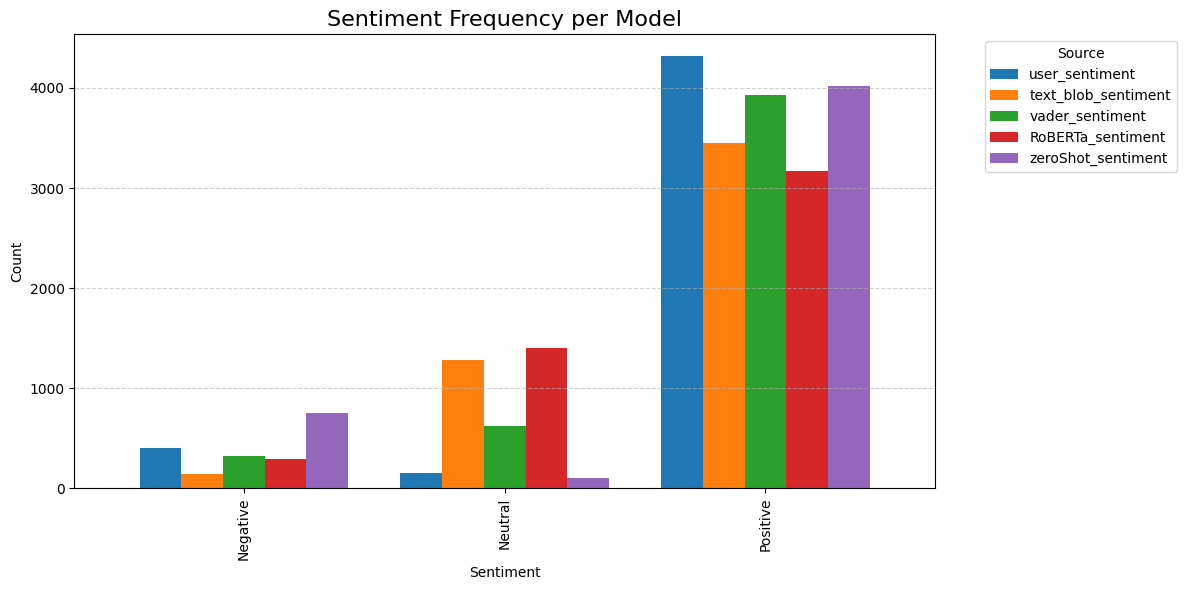

In [42]:
## Plotting Sentiment counts

sentiment_counts = pd.DataFrame()
for col in ['user_sentiment', 'text_blob_sentiment', 'vader_sentiment', 'RoBERTa_sentiment', 'zeroShot_sentiment']:
    sentiment_counts[col] = data_reviews[col].value_counts().sort_index()

sentiment_counts = sentiment_counts.fillna(0).astype(int)

sentiment_counts.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('Sentiment Frequency per Model', fontsize=16)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


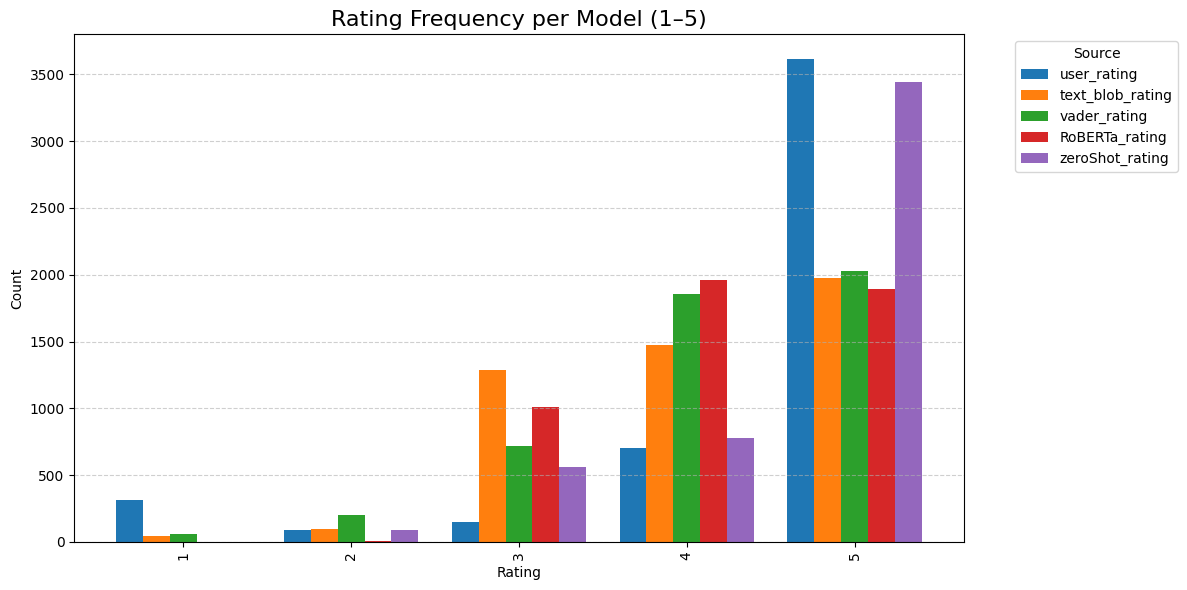

In [43]:
## Plotting Rating counts

rating_counts = pd.DataFrame()
for col in ['user_rating', 'text_blob_rating', 'vader_rating', 'RoBERTa_rating', 'zeroShot_rating']:
    rating_counts[col] = data_reviews[col].value_counts().sort_index()

rating_counts = rating_counts.fillna(0).astype(int)

rating_counts.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('Rating Frequency per Model (1–5)', fontsize=16)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


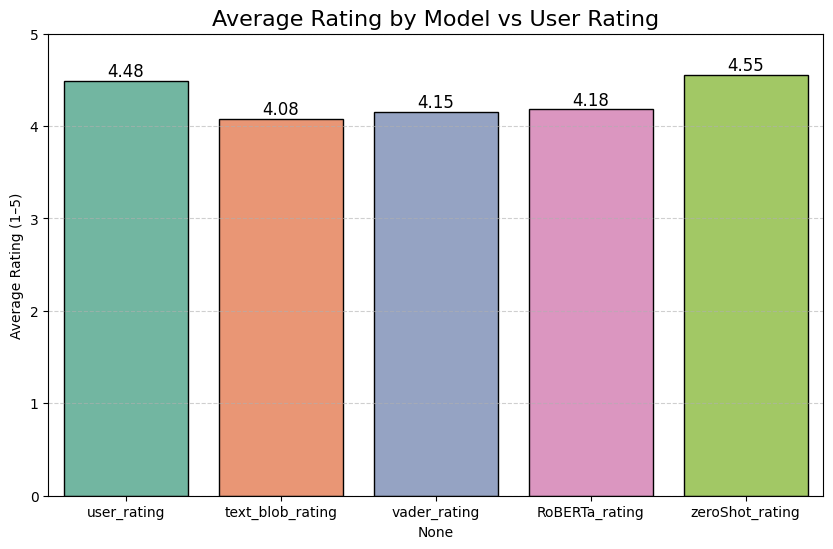

In [44]:
### Plotting average ratings

avg_ratings = data_reviews[['user_rating', 'text_blob_rating', 'vader_rating', 'RoBERTa_rating', 'zeroShot_rating']].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_ratings.index, y=avg_ratings.values, palette='Set2', edgecolor='black')

plt.title('Average Rating by Model vs User Rating', fontsize=16)
plt.ylabel('Average Rating (1–5)')
plt.ylim(0, 5)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate the bars
for i, val in enumerate(avg_ratings.values):
    plt.text(i, val + 0.05, f"{val:.2f}", ha='center', fontsize=12)

plt.show()


In [45]:
data_reviews.dropna(inplace=True)
data_reviews.shape

(4870, 17)

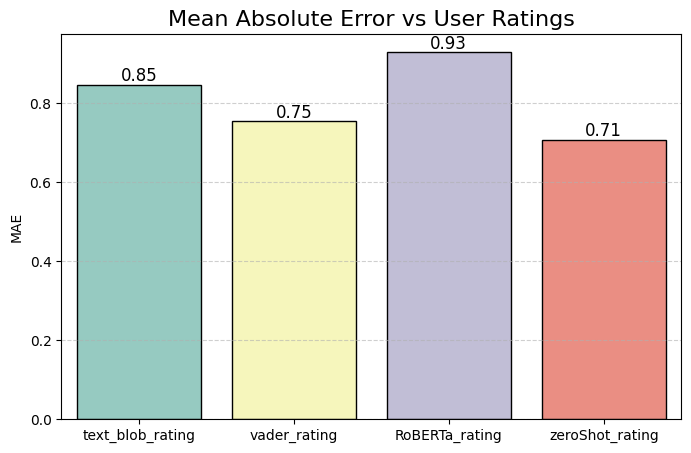

In [46]:
from sklearn.metrics import mean_absolute_error

mae = {
    model: mean_absolute_error(data_reviews['user_rating'], data_reviews[model])
    for model in ['text_blob_rating', 'vader_rating', 'RoBERTa_rating', 'zeroShot_rating']
}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(mae.keys()), y=list(mae.values()), palette='Set3', edgecolor='black')
plt.title("Mean Absolute Error vs User Ratings", fontsize=16)
plt.ylabel("MAE")
for i, val in enumerate(mae.values()):
    plt.text(i, val + 0.01, f"{val:.2f}", ha='center', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [47]:
### Finding diagreements
def find_disagreement(row):
    sentiments = [row['user_rating'], row['text_blob_rating'], row['vader_rating'], row['RoBERTa_rating'], row['zeroShot_rating']]
    return len(set(sentiments)) > 2

# Apply
data_reviews['disagreement'] = data_reviews.apply(find_disagreement, axis=1)

# View examples
disagreements = data_reviews[data_reviews['disagreement'] == True]
disagreements[['raw_review_text', 'user_rating' ,'text_blob_rating', 'vader_rating', 'RoBERTa_rating', 'zeroShot_rating']].head()


,raw_review_text,user_rating,text_blob_rating,vader_rating,RoBERTa_rating,zeroShot_rating
1,Very bad experience with this iPhone xr phone....,1,2,1,5,5
3,So I got the iPhone XR just today. The product...,1,3,5,3,5
5,I was delivered a phone that did not work imme...,1,3,1,4,5
7,The phone is hanging. Video quality is not ver...,1,5,4,4,5
8,I'll use this review to mostly say what I'm no...,4,3,3,5,5


### Extracting top Positive/Negative Words using VADER with Zero Shot as base

In [48]:
def extract_pos_neg_words(text):
    words = re.findall(r'\b\w+\b', text.lower())  # tokenize words
    pos_words, neg_words = [], []
    for word in words:
        score = vader_analyzer.polarity_scores(word)['compound']
        if score >= 0.5:
            pos_words.append(word)
        elif score <= -0.5:
            neg_words.append(word)
    return pos_words, neg_words

In [49]:
cluster_pos_words = {}
cluster_neg_words = {}

for cluster, group in data_reviews.groupby('zeroShot_sentiment'):
    all_pos = []
    all_neg = []
    for review in group['review_text']:
        pos, neg = extract_pos_neg_words(review)
        all_pos.extend(pos)
        all_neg.extend(neg)
    cluster_pos_words[cluster] = Counter(all_pos).most_common(10)
    cluster_neg_words[cluster] = Counter(all_neg).most_common(10)


In [50]:
def plot_pos_neg_words(pos_words, neg_words, title="Top Sentiment Words"):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    if pos_words:
        words, counts = zip(*pos_words)
        axes[0].barh(words, counts, color='green')
        axes[0].set_title("Positive Words")
        axes[0].invert_yaxis()
    else:
        axes[0].text(0.5, 0.5, 'No Positive Words', ha='center', va='center')
        axes[0].axis('off')
    
    if neg_words:
        words, counts = zip(*neg_words)
        axes[1].barh(words, counts, color='red')
        axes[1].set_title("Negative Words")
        axes[1].invert_yaxis()
    else:
        axes[1].text(0.5, 0.5, 'No Negative Words', ha='center', va='center')
        axes[1].axis('off')
    
    for ax in axes:
        ax.set_xlabel("Frequency")
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

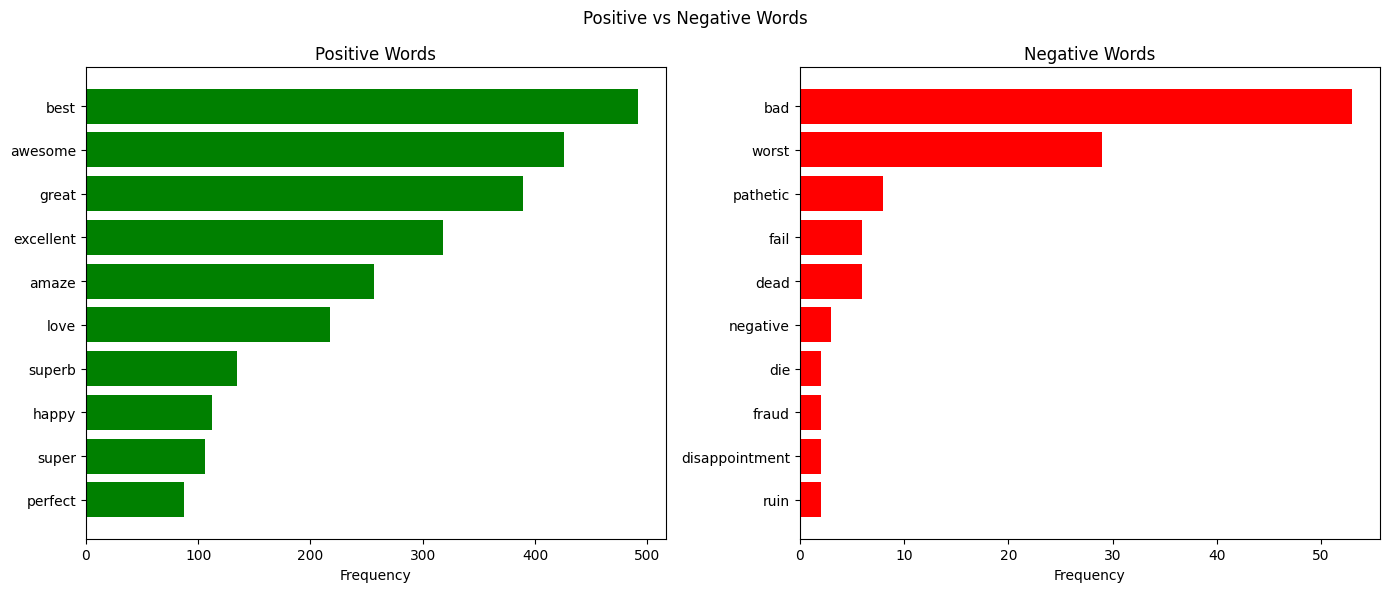

In [51]:
plot_pos_neg_words(cluster_pos_words['Positive'], cluster_neg_words['Negative'], title="Positive vs Negative Words")

### Top Positive and Negtative Sentences

In [52]:
positive_sentences = []
negative_sentences = []

# Replace this with your actual column:
text_column = raw_data['review_text']

for review in text_column.dropna():
    sentences = sent_tokenize(review)
    for sentence in sentences:
        score = vader_analyzer.polarity_scores(sentence)['compound']
        if score >= 0.7:
            positive_sentences.append(sentence)
        elif score <= -0.3:
            negative_sentences.append(sentence)

            
print("🟢 Top 5 Positive Sentences:")
for s in positive_sentences[:10]:
    print("-", s)

print("\n🔴 Top 5 Negative Sentences:")
for s in negative_sentences[:10]:
    print("-", s)


🟢 Top 5 Positive Sentences:
- Amazing phone with amazing camera coming from iPhone 7 plus great service from amazon
- Loving the camera and battery life is an absolute joy to have.
- Face ID works flawlessly even in the dark and the dual sim function is working like a charm, I'm using Vodafone as my primary sim and Jio as e-sim and have faced no problem whatsoever.
- Excellent battery life, smooth operating system, and most of all, dual Sim functionality are the best features of this iPhone.
- Spent so many days to decide on the colour, but opted for white, and I’m very happy about it.
- Best mobile  and my favourite Where nice XR Amazing futures and best camera so thanks for  Amazon
- It’s heavy but looks are so attractive that you will be ready to carry that little extra weight.
- Great Phone, I am happy with the phone so far.
- The premium feel of the product is completely let down and left to enjoy is a good software interface of ios and an excellent camera.
- Well to be frank i su

### N-Grams Analysis

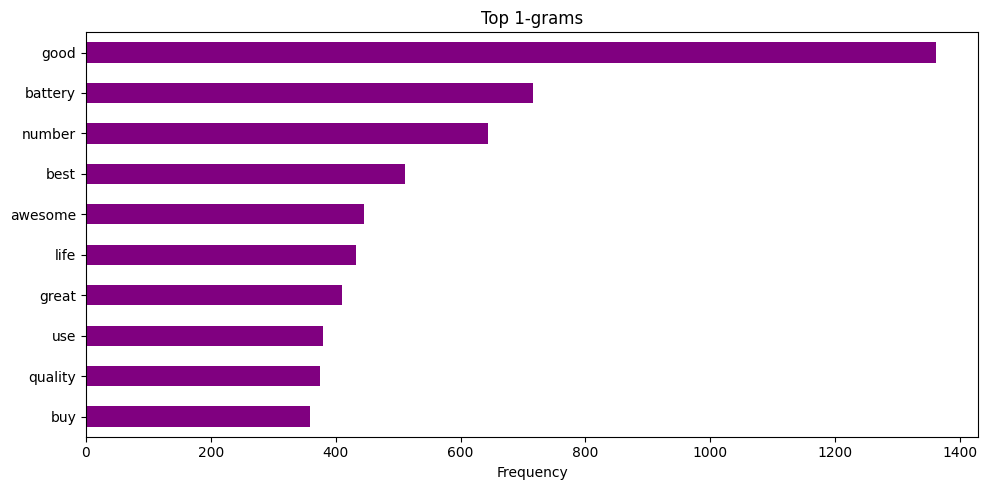

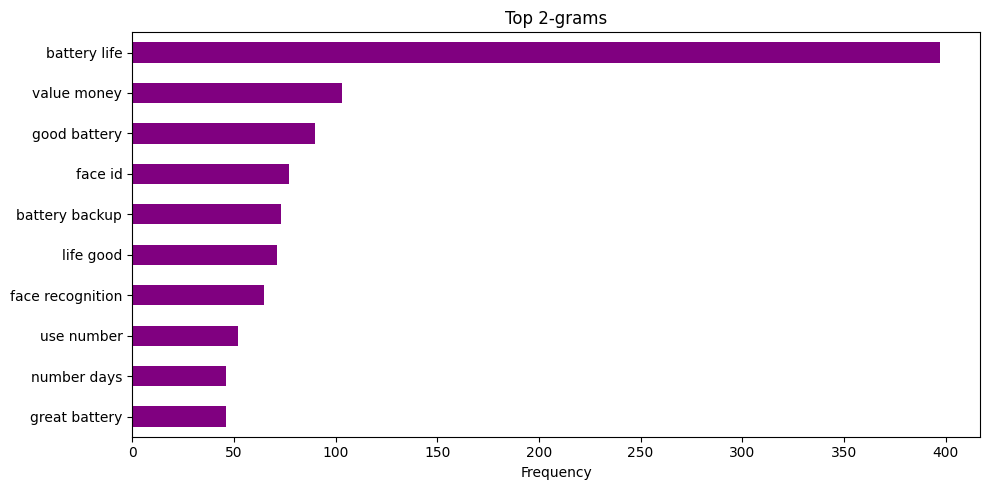

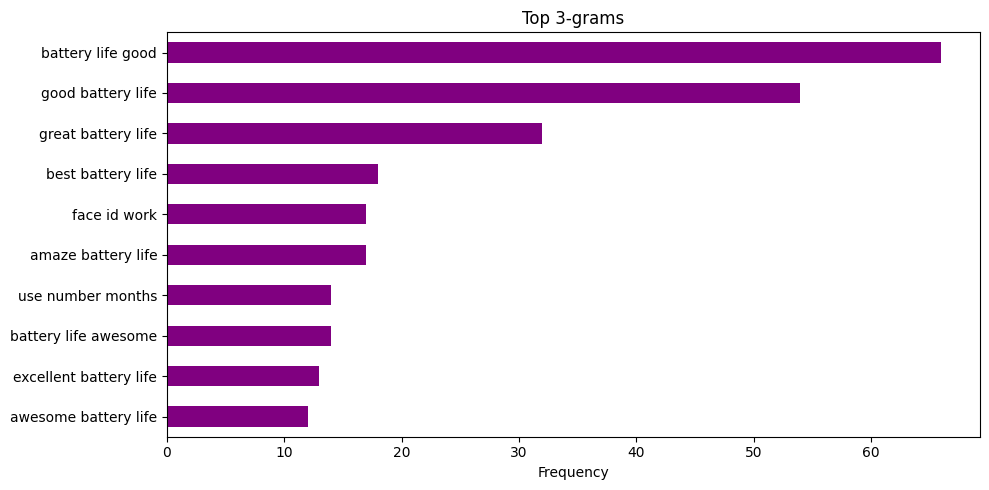

In [53]:
def get_ngrams(texts, n=2, top_k=10):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english')
    X = vec.fit_transform(texts)
    ngram_counts = X.sum(axis=0).A1
    vocab = vec.get_feature_names_out()
    ngram_freq = pd.Series(ngram_counts, index=vocab)
    return ngram_freq.sort_values(ascending=False).head(top_k)

for n in [1, 2, 3]:
    top_ngrams = get_ngrams(data['review_text'], n=n)
    plt.figure(figsize=(10, 5))
    top_ngrams.plot(kind='barh', title=f"Top {n}-grams", color='purple')
    plt.gca().invert_yaxis()
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()

### Getting GeoEmotions for each review

In [55]:
tokenizer = AutoTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-original")
model = AutoModelForSequenceClassification.from_pretrained("monologg/bert-base-cased-goemotions-original")
model.eval()

labels = list(model.config.id2label.values())

# Your data (ensure 'review_text' column exists)
texts = data_reviews['review_text'].fillna('').tolist()

# Store results
dominant_emotion_labels = []
dominant_emotion_scores = []

# Batch processing
batch_size = 32
with torch.no_grad():
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        tokens = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
        outputs = model(**tokens)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()  # Multi-label output
        
        for prob in probs:
            max_idx = prob.argmax()
            dominant_emotion_labels.append(labels[max_idx])
            dominant_emotion_scores.append(prob[max_idx])

# Add to DataFrame
data['dominant_emotion'] = dominant_emotion_labels
data['emotion_score'] = np.round(dominant_emotion_scores,2)

100%|██████████| 153/153 [02:26<00:00,  1.05it/s]


In [56]:
data_reviews [['emotion','confidence_Score']] = data [['dominant_emotion','emotion_score']].copy()

In [57]:
data_reviews.emotion.value_counts().head(7)

emotion
admiration        2408
disappointment    1628
embarrassment      235
sadness            129
desire             117
realization         98
remorse             62
Name: count, dtype: int64

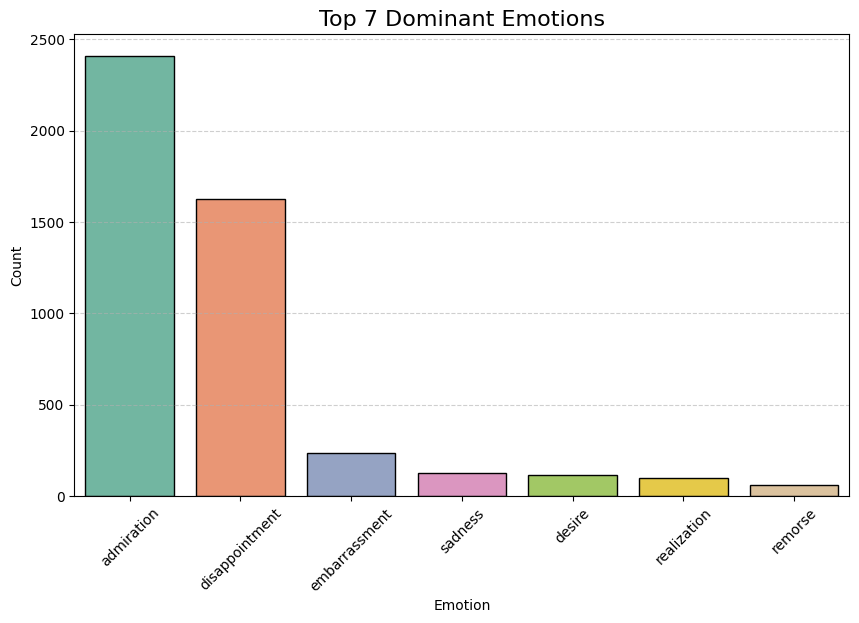

In [58]:
plt.figure(figsize=(10, 6))
sns.barplot(x=data_reviews.emotion.value_counts().head(7).index, y=data_reviews.emotion.value_counts().head(7).values, palette='Set2', edgecolor='black')

plt.title('Top 7 Dominant Emotions', fontsize=16)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
